In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_dir = '../dataset/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')
test_dir = os.path.join(base_dir, 'test/')
batch_size = 32
epochs = 10
IMG_SIZE = (224, 224)
im_height = 224
im_width = 224

In [3]:
# 定义训练集图像生成器，并进行图像增强
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,  # 归一化
                                            rotation_range=40, #旋转范围
                                            width_shift_range=0.2, #水平平移范围
                                            height_shift_range=0.2, #垂直平移范围
                                            shear_range=0.2, #剪切变换的程度
                                            zoom_range=0.2, #缩放范围
                                            horizontal_flip=True,  #水平翻转
                                            fill_mode='nearest')  
                                             
# 使用图像生成器从文件夹train_dir中读取样本，对标签进行one-hot编码
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,   #打乱数据
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
# 训练集样本数    
total_train = train_data_gen.n

# 定义验证集图像生成器，并对图像进行预处理
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)  #归一化

# 使用图像生成器从验证集validation_dir中读取样本
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,  #不打乱数据
                                                              target_size=(im_height, im_width),
                                                              class_mode='categorical')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                            batch_size=batch_size,
                                            image_size=IMG_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                            batch_size=batch_size,
                                            image_size=IMG_SIZE)
class_names = test_dataset.class_names
print(class_names)
# 验证集样本数    
total_val = val_data_gen.n


Found 644 images belonging to 4 classes.
Found 113 images belonging to 4 classes.
Found 644 files belonging to 4 classes.
Found 77 files belonging to 4 classes.
['fire_hydrant_pump_start_button', 'fire_telephone', 'heat_fire_detector', 'smoke_fire_detector']


In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                            batch_size=batch_size,
                                            image_size=IMG_SIZE)

Found 644 files belonging to 4 classes.


In [5]:
#使用tf.keras.applications中的MobileNetV2网络，并且使用官方的预训练模型
covn_base = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),weights='imagenet',include_top=False)
covn_base.trainable = True

In [6]:
#冻结前面的层，训练最后五层
for layers in covn_base.layers[:-5]:
    layers.trainable = False
    
#构建模型    
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.GlobalAveragePooling2D()) #加入全局平均池化层
# model.add(tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1(0.001), activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names),activation='softmax')) #加入输出层(多分类)

In [7]:
#编译模型
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  #使用adam优化器，学习率为0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #交叉熵损失函数
              metrics=["accuracy"])  #评价函数
# 每层参数信息              
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
 dense_1 (Dense)             (None, 4)                 44        


                                                                 
Total params: 2270838 (8.66 MB)
Trainable params: 732854 (2.80 MB)
Non-trainable params: 1537984 (5.87 MB)
_________________________________________________________________


In [8]:
#开始训练
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)
loss, accuracy = model.evaluate(val_data_gen)
print(loss)
print(accuracy)

Epoch 1/10
20/20 [==============================] - 20s 874ms/step - loss: 0.8760 - accuracy: 0.6405 - val_loss: 0.7460 - val_accuracy: 0.9167
Epoch 2/10
20/20 [==============================] - 16s 795ms/step - loss: 0.2670 - accuracy: 0.9755 - val_loss: 0.4071 - val_accuracy: 0.9062
Epoch 3/10
20/20 [==============================] - 16s 799ms/step - loss: 0.0747 - accuracy: 0.9967 - val_loss: 0.2615 - val_accuracy: 0.9688
Epoch 4/10
20/20 [==============================] - 16s 807ms/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2091 - val_accuracy: 0.9688
Epoch 5/10
20/20 [==============================] - 16s 810ms/step - loss: 0.0259 - accuracy: 0.9984 - val_loss: 0.2110 - val_accuracy: 0.9062
Epoch 6/10
20/20 [==============================] - 17s 840ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.8750
Epoch 7/10
20/20 [==============================] - 17s 826ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.1952 - val_accuracy: 0.9167

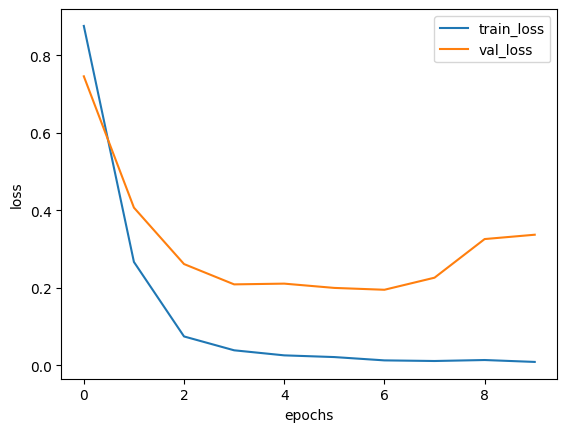

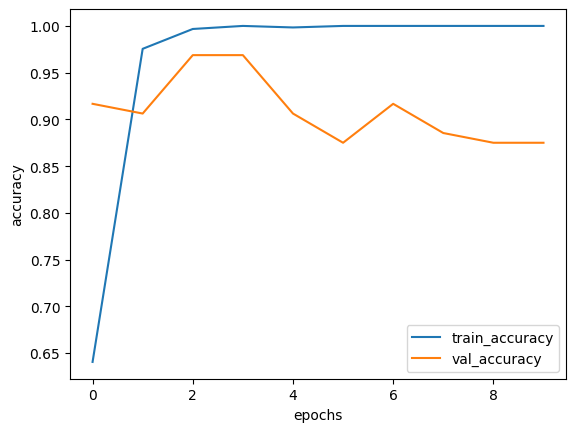

In [9]:
# 记录训练集和验证集的准确率和损失值
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# 绘制损失值
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# 绘制准确率
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [10]:
def load_and_process_image(img_path):
    '''把单个图片解析并预处理'''
    img_raw = tf.io.read_file(img_path) #读文件
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3) #解析成向量
    img_tensor = tf.image.resize(img_tensor, [224, 224]) #调整向量维度
    #因为需要和image_dataset_from_directory制作的dataset维度一致，所以增加一维
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_tensor = tf.cast(img_tensor, dtype=tf.float32) #转成tf格式
    return img_tensor

img = load_and_process_image('../dataset/test/heat_fire_detector/01.jpg')
predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 708ms/step
This image most likely belongs to heat_fire_detector with a 33.43 percent confidence.


Predictions:
 [0 0 0 0 1 1 0 1 0 0 0 0 2 0 0 0 1 2 1 0 2 3 2 0 0 2 1 0 0 3 1 0]
Labels:
 [0 0 1 0 1 1 3 1 3 3 0 1 2 0 0 3 1 2 1 0 2 3 2 0 3 2 1 1 1 3 1 1]


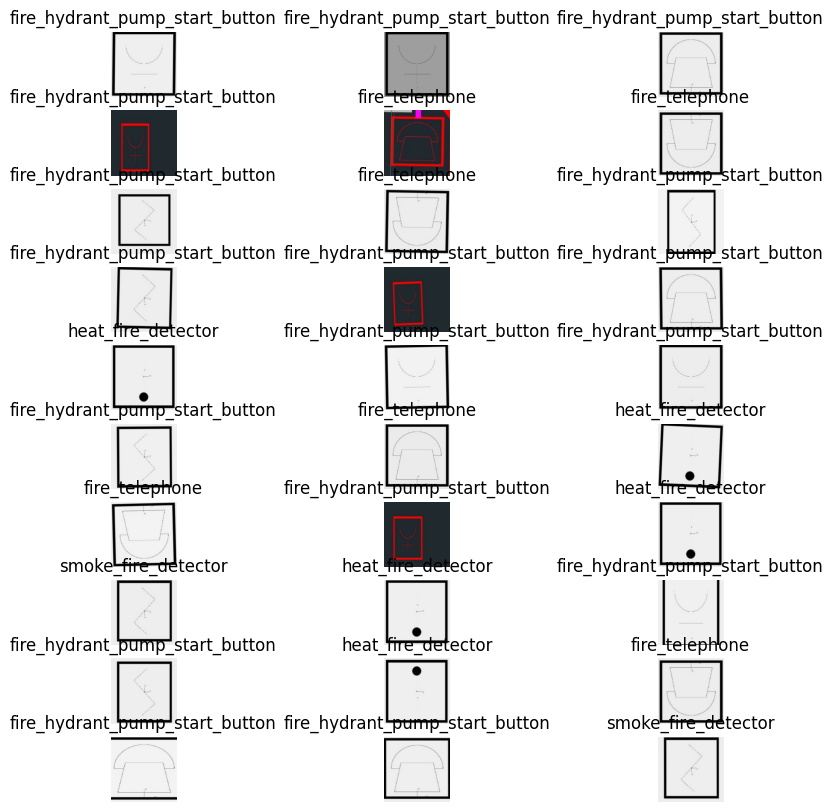

In [11]:
# 迭代式获取数据信息
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# 预测结果
predictions = model.predict_on_batch(image_batch)
# 直接argmax查看数据
predictions = tf.argmax(predictions, axis=1)

# 获取标签
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# 画图
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(10, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")